##TTim Pumping Test

In [2]:
# import ttim, numpy, matplotlib
from ttim import *
from pylab import *
%matplotlib inline

This exercise concerns the evaluation of the pumping test near the town of Oude Korendijk, described in the book 'Analysis and evaluation of pumping test data' by Kruseman and de Ridder. A pumping test was conducted in a confined aquifer extending form 18 m to 25 m below surface. The well penetrates the aquifer fully and is pumped at 788 m$^3$/day. Drawdown is measured in two observation wells, one at 30 m from the pumping well and one at 90 m from the pumping well. The data is provided in the files `oudekorendijk30.dat` and `oudekorendijk90.dat`. Time is given in minutes and drawdown in meters. Time is converted to days and drawdown to heads.

In [3]:
observed = loadtxt('oudekorendijk_h30.dat')
to1 = observed[:,0] / 60.0 / 24.0
ho1 = -observed[:,1]
ro1 = 30.0
observed = loadtxt('oudekorendijk_h90.dat')
to2 = observed[:,0] / 60.0 / 24.0
ho2 = -observed[:,1]
ro2 = 90.0
Qo = 788.0

A function is written that creates a ttim model, computes the head at the observation well and returns the sum of squared errors between the observed heads and the modeled heads. `tmin` and `tmax` are selected to match the data. Input arguments of the function are the hydraulic conductivity and the specific storage coefficient of the aquifer. The function takes a second optional argument `returnheads` which returns the heads rather than the sum of squared errors, which comes in handy once the optimal values of the parameters are found

In [4]:
from lmfit import Parameters, minimize, fit_report

In [5]:
def residual(p, t=None, rdata=None, data=None):
    vals = p.valuesdict()
    k =  vals['k']
    Ss =  vals['Ss']
    rc = vals['rc']
    ml = ModelMaq(kaq=k, z=(-18,-25), Saq=Ss, tmin=1e-5, tmax=1)   
    w = Well(ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=0, rc=rc)
    ml.solve(silent='.')
    hm = ml.head(rdata, 0.0, t, layers=[0])
    if data is None:
        return hm[0]
    else:
        return hm[0] - data  # head in layer 0

Define the parameters $k$ and $S_s$ and give starting values for the parameter optimization

In [6]:
p = Parameters()
p.add('k', value=10.0)
p.add('Ss', value=1e-4)
p.add('rc', value=0, vary=False)

Determine the optimal parameters using the measurements in the observation well 30 m from the pumping well. Note that the parameter `epsfcn=1e-4` is crucial. This parameter is used to estimate a nuerical approximation of the Jacobian matrix. 

In [7]:
print 'Parameter estimation using data at observation well 30 m'
p30 = minimize(residual, p, kws={'t':to1, 'rdata':ro1, 'data':ho1}, epsfcn=1e-4)
print 
print fit_report(p30.params)

Parameter estimation using data at observation well 30 m
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[[Variables]]
    k:    68.6395748 +/- 1.438330 (2.10%) (init= 10)
    Ss:   1.6071e-05 +/- 1.58e-06 (9.85%) (init= 0.0001)
    rc:   0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(k, Ss)                     = -0.891 


In [8]:
print 'Parameter estimation using data at observation well 90 m'
p90 = minimize(residual, p, kws={'t':to2, 'rdata':ro2, 'data':ho2}, epsfcn=1e-4)
print 
print fit_report(p90.params)

Parameter estimation using data at observation well 90 m
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[[Variables]]
    k:    71.5805516 +/- 1.574150 (2.20%) (init= 10)
    Ss:   2.9110e-05 +/- 1.94e-06 (6.66%) (init= 0.0001)
    rc:   0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(k, Ss)                     = -0.847 


. .


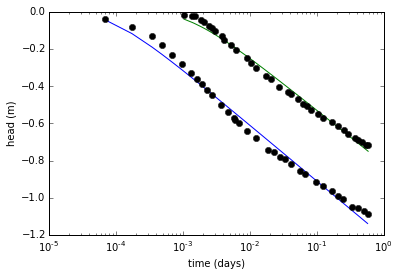

In [9]:
h30 = residual(p30.params, t=to1, rdata=ro1, data=None)
h90 = residual(p90.params, t=to2, rdata=ro2, data=None)
semilogx(to1, h30, label='30 m')
semilogx(to1, ho1, 'ko')
semilogx(to2, h90, label='90 m')
semilogx(to2, ho2, 'ko')
xlabel('time (days)')
ylabel('head (m)');

Kruseman and de Ridder report optimal values obtained in a variety of ways and on both datasets as $T=370-437$ m$^2$/d and $S=1.6\cdot 10^{-4}-4.1\cdot 10^{-4}$. Optimal values with this first analysis are a bit higher for $T$ and a bit lower for $S$, while the fit is pretty good.

In [10]:
print '30 m T and S:', p30.params['k'].value * 7, p30.params['Ss'].value * 7
print '90 m T and S:', p90.params['k'].value * 7, p90.params['Ss'].value * 7

30 m T and S: 480.477023725 0.000112499108037
90 m T and S: 501.06386131 0.000203767382683


###Wellbore storage
Kruseman and De Ridder don't include wellbore storage in their well, although early response of the well suggests wellbore storage is not negligible. Wellbore storage can be included and gives a better fit (lower sum of squared errors). In the example below a fixed well radius for wellbore storage of $r_c=0.2$ m is used, although this parameter may also be fitted. 

Parameter estimation using data at observation well 30 m with wellbore storage
. . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[[Variables]]
    k:    74.7090458 +/- 1.031020 (1.38%) (init= 10)
    Ss:   9.4804e-06 +/- 6.98e-07 (7.36%) (init= 0.0001)
    rc:   0.2 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(k, Ss)                     = -0.907 
Parameter estimation using data at observation well 90 m with wellbore storage
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[[Variables]]
    k:    73.2474398 +/- 1.385888 (1.89%) (init= 10)
    Ss:   2.6501e-05 +/- 1.57e-06 (5.92%) (init= 0.0001)
    rc:   0.2 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(k, Ss)                     = -0.848 
30 m T and S: 522.9633212 6.63627945489e-05
90 m T and S: 512.732079008 0.000185510046453
. .


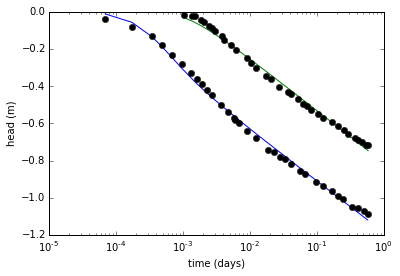

In [11]:
p['rc'].value = 0.2
p['rc'].vary = False

print 'Parameter estimation using data at observation well 30 m with wellbore storage'
p30rc = minimize(residual, p, kws={'t':to1, 'rdata':ro1, 'data':ho1}, epsfcn=1e-4)
print 
print fit_report(p30rc.params)

print 'Parameter estimation using data at observation well 90 m with wellbore storage'
p90rc = minimize(residual, p, kws={'t':to2, 'rdata':ro2, 'data':ho2}, epsfcn=1e-4)
print 
print fit_report(p90rc.params)

print '30 m T and S:', p30rc.params['k'].value * 7, p30rc.params['Ss'].value * 7
print '90 m T and S:', p90rc.params['k'].value * 7, p90rc.params['Ss'].value * 7

h30rc = residual(p30rc.params, t=to1, rdata=ro1, data=None)
h90rc = residual(p90rc.params, t=to2, rdata=ro2, data=None)
semilogx(to1, h30rc, label='30 m')
semilogx(to1, ho1, 'ko')
semilogx(to2, h90rc, label='90 m')
semilogx(to2, ho2, 'ko')
xlabel('time (days)')
ylabel('head (m)');

###Semi-confined layer below
Kruseman and De Ridder suggests that the confined aquifer may be underlain by a clay layer that leaks a bit of water. This may be seen from the data, where the observations seem to indicate a slight leveling-off of the drawdown and then a second increase due to release from the aquifer below. Mind you this is all fairly suttle, and may not be realistic, but it is easy to try to simulate the aquifer with an additional leaky layer. TTim requires this additional layer to be on top of the aquifer, but that gives the exact same mathematical solution as at the bottom of the aquifer (for a system consisting of one aquifer). The thickness of the additional layer is not important if the storage of the leaky layer is neglected. When the model is fitted, it should be prevented that one of the parameters becomes negative, which is obviously unrealistic and may lead to impossible solutions. Such safeguards are not built in here, and the optimization algorithm is able to find a solution, although quite a few iterations are needed. 

In [12]:
def residual_semi(p, t=None, rdata=None, data=None):
    vals = p.valuesdict()
    k =  vals['k']
    Ss =  vals['Ss']
    rc = vals['rc']
    c = vals['c']
    ml = ModelMaq(kaq=k, z=(-10, -18,-25), Saq=Ss, c=c, topboundary='semi', tmin=1e-5, tmax=1)   
    w = Well(ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=0, rc=rc)
    ml.solve(silent='.')
    hm = ml.head(rdata, 0.0, t, layers=[0])
    if data is None:
        return hm[0]
    else:
        return hm[0] - data  # head in layer 0

In [13]:
p.add('c', value=5000, min=1, max=1e5)
print 'Parameter estimation using data at observation well 30 m, wellbore storage and semi confining layer'
p30rcsemi = minimize(residual_semi, p, kws={'t':to1, 'rdata':ro1, 'data':ho1}, epsfcn=1e-4)
print 
print fit_report(p30rcsemi.params)

Parameter estimation using data at observation well 30 m, wellbore storage and semi confining layer
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[[Variables]]
    k:    69.2868718 +/- 1.048104 (1.51%) (init= 10)
    Ss:   1.1747e-05 +/- 6.53e-07 (5.56%) (init= 0.0001)
    rc:   0.2 (fixed)
    c:    7944.13150 +/- 1.55e+03 (19.54%) (init= 5000)
[[Correlations]] (unreported correlations are <  0.100)
    C(k, Ss)                     = -0.904 
    C(k, c)                      =  0.884 
    C(Ss, c)                     = -0.716 


In [14]:
print 'Parameter estimation using data at observation well 90 m, wellbore storage and semi confining layer'
p90rcsemi = minimize(residual_semi, p, kws={'t':to2, 'rdata':ro2, 'data':ho2}, epsfcn=1e-4)
print 
print fit_report(p90rcsemi.params)

Parameter estimation using data at observation well 90 m, wellbore storage and semi confining layer
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[[Variables]]
    k:    63.5216901 +/- 1.399284 (2.20%) (init= 10)
    Ss:   3.0175e-05 +/- 1.09e-06 (3.62%) (init= 0.0001)
    rc:   0.2 (fixed)
    c:    2631.12270 +/- 712.0474 (27.06%) (init= 5000)
[[Correlations]] (unreported correlations are <  0.100)
    C(k, c)                      =  0.913 
    C(k, Ss)                     = -0.780 
    C(Ss, c)                     = -0.596 


. .

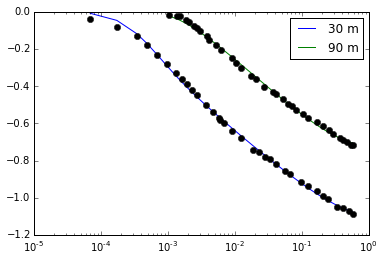

In [15]:
h30rcsemi = residual_semi(p30rcsemi.params, t=to1, rdata=ro1, data=None)
h90rcsemi = residual_semi(p90rcsemi.params, t=to2, rdata=ro2, data=None)
semilogx(to1, h30rcsemi, label='30 m')
semilogx(to1, ho1, 'ko')
semilogx(to2, h90rcsemi, label='90 m')
semilogx(to2, ho2, 'ko')
legend(loc='best')

###Noise model

In [62]:
def residual_noise(p, t=None, rdata=None, data=None, sim=None):
    vals = p.valuesdict()
    k =  vals['k']
    Ss =  vals['Ss']
    rc = vals['rc']
    alpha = vals['alpha']
    ml = ModelMaq(kaq=k, z=(-18,-25), Saq=Ss, tmin=1e-5, tmax=1)   
    w = Well(ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=0, rc=rc)
    ml.solve(silent='.')
    hm = ml.head(rdata, 0.0, t, layers=[0])
    if data is None:
        return hm[0]
    dt = t[1:] - t[:-1]
    r = hm[0] - data
    if sim == 'res':
        return r
    v = r[1:] - np.exp(-dt / alpha) * r[:-1]
    v = v / np.sqrt(1 - np.exp(-2 * dt / alpha)) * prod(1-exp(-2*dt/alpha))**(1.0/(2*len(dt)))
    return v

In [63]:
p = Parameters()
p.add('k', value=10.0)
p.add('Ss', value=1e-4)
p.add('rc', value=0.2, vary=False)
p.add('alpha', value=1.0/60/24)

In [64]:
print 'r=30 m, rc=0.2 m, noise model'
p30noise = minimize(residual_noise, p, kws={'t':to1, 'rdata':ro1, 'data':ho1}, epsfcn=1e-4)
print 
print fit_report(p30noise.params)

r=30 m, rc=0.2 m, noise model
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[[Variables]]
    k:       70.8392055 +/- 1.208756 (1.71%) (init= 10)
    Ss:      1.5100e-05 +/- 1.36e-06 (8.98%) (init= 0.0001)
    rc:      0.2 (fixed)
    alpha:   0.01662457 +/- 0.009056 (54.47%) (init= 0.0006944444)
[[Correlations]] (unreported correlations are <  0.100)
    C(k, Ss)                     = -0.729 
    C(Ss, alpha)                 =  0.206 


.


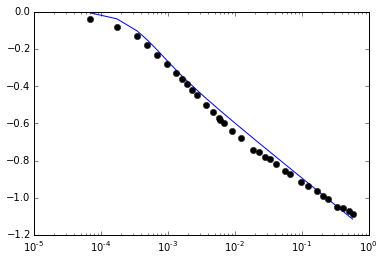

In [65]:
h30noise = residual_noise(p30noise.params, t=to1, rdata=ro1, data=None)
semilogx(to1, h30noise, label='30 m')
semilogx(to1, ho1, 'ko');

. .


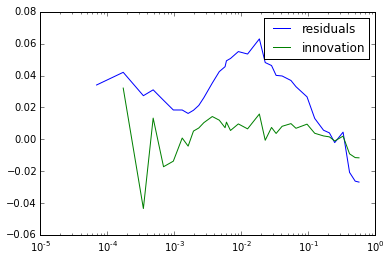

In [66]:
h30res = residual_noise(p30noise.params, t=to1, rdata=ro1, data=ho1, sim='res')
h30inn = residual_noise(p30noise.params, t=to1, rdata=ro1, data=ho1)
semilogx(to1, h30res, label='residuals')
semilogx(to1[1:], h30inn, label='innovation')
legend();

In [61]:
alpha = 0.00054309
dt = to1[1:] - to1[:-1]
prod(1-exp(-2*dt/alpha))**(1.0/(2*len(dt)))

0.91284722143410202